# Sipariş Verisi Analizi ve Servis Alanlarının Belirlenmesi


Açıklama


## Metodoloji


## Hazırlık

### Çalışma alanının belirlenmesi


Verileri indirmeden önce, ilgi alanının koordinatlarını tanımlayacağız. Bu koordinatlara dayanarak, veri kümelerini daha ileri işlemeler için kırpabileceğiz ve sonunda seçilen alan için sipariş verisini ve servis alanlarını görüntüleyebileceğiz.

Coğrafi koordinatlar cinsinden bir alanı kolayca tanımlamak için [Bounding Box Tool](https://boundingbox.klokantech.com/) adresine giderek bir bölge seçebilir ve koordinatları alabiliriz. Buradaki değerlerin kullanılabilmesi için sol alt köşeden 'CSV' seçeneğini seçtiğinizden emin olun ve ardından köşeli parantez içindeki değerleri kopyalayın. Koordinatların yanı sıra, grafiklerde ve kaydedilen sonuçlarda kullanılacak alan için bir isim belirtmeniz gerekmektedir. Koordinatların WGS84 koordinat sisteminde (EPSG:4326) belirtilmektedir.


In [9]:
## name of the area
areaname = 'Bursa'
# bbox = [longitude_min, latitude_min, longitude_max, latitude_max]
bbox = [28.0818,39.5695,29.9549,40.645]

## example:
# areaname = 'Istanbul'
# bbox = [28.966667,40.966667,29.216667,41.116667]

### Kütüphanelerin yüklenmesi


Bu not defterinde aşağıdaki Python kütüphanelerini kullanacağız:

- [pandas](https://pandas.pydata.org/) - Tablo şeklindeki verilerle çalışmak için temel bir veri işleme ve analiz kütüphanesidir.
- [geopandas](https://geopandas.org/) - Coğrafi verileri analiz etmek ve görselleştirmek için pandas'ı genişleten bir kütüphane.
- [psycopg2](https://www.psycopg.org/docs/) - PostgreSQL veritabanları ile bağlantı kurmak ve SQL sorguları çalıştırmak için kullanılan bir veritabanı adaptörüdür.
- [plotly](https://plotly.com/python/) - Etkileşimli grafikler, haritalar ve görselleştirmeler oluşturmak için güçlü bir kütüphane.
- [requests](https://docs.python-requests.org/en/latest/) - HTTP istekleri göndermek ve API'lerden veri almak için kullanılan basit ve etkili bir kütüphane.
- [osmnx](https://osmnx.readthedocs.io/en/stable/) - OpenStreetMap verilerini indirip, analiz edip, görselleştirmek için kullanılan bir kütüphane.

Bu kütüphaneler, coğrafi ve sayısal verilerin indirilmesi, işlenmesi, analiz edilmesi ve görselleştirilmesini sağlar.


In [10]:
# for downloading data and managing files
import os
import requests

# data analysis and table operations
import pandas as pd
from scipy.stats import gaussian_kde
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi

# working with geospatial data (shapefile, GeoJSON, etc.)
import geopandas as gpd
from shapely.geometry import box, Point, Polygon, MultiPolygon

# for interactive graphs and map-based visualizations
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
import contextily as ctx

# for downloading, analyzing and visualizing OSM data
import osmnx as ox

### Dosya yapısının oluşturulması


Analiz sürecinde verilerin ve çıktıların düzenli bir şekilde saklanabilmesi için klasörleme sistemi oluşturuyoruz. Böylece veri dosyaları ve görseller gibi farklı içerikler kolayca yönetilebilir ve tekrar erişilebilir.

In [11]:
# define the folder for the workflow
workflow_folder = 'ORDERS_SERVICE_AREA'

# check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [12]:
# define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

### Çalışma alanına ait coğrafi verilerin temini ve görüntülenmesi

Yol verileri için OSMnx kütüphanesi aracılığılıyla OpenStreetMap'ten ve idari sınırlar için Bursa Açık Veri Platformu'nu kullanıyoruz. Verilerin güncelliğini korumak maksatıyla bir defaya mahsus webten temin edilmesi gerekmektedir ve bu işlem ortalama bir internet bağlantısı ile bir dakikada gerçekleşmektedir.

In [13]:
# convert bounding box to polygon
def create_bbox_polygon(bbox):
    return box(*bbox)

# download road network or if it's downloaded before, load from file (it takes a minute to download with an average network speed)
def get_road_network(bbox, filepath):
    if os.path.exists(filepath):
        print("Yol ağı dosyadan yükleniyor")
        return ox.load_graphml(filepath)
    else:
        print("Yol ağı indiriliyor")
        polygon = create_bbox_polygon(bbox)
        G = ox.graph_from_polygon(polygon, network_type='drive')
        ox.save_graphml(G, filepath)
        return G

# download admin boundaries by area name or if it's downloaded before, load from file
def get_bursa_admin_data(districts_filepath, nbh_filepath):
    districts_gdf = gpd.GeoDataFrame()
    nbh_gdf = gpd.GeoDataFrame()
    
    # ilce
    if os.path.exists(districts_filepath):
        print("İlçe verileri dosyadan yükleniyor")
        districts_gdf = gpd.read_file(districts_filepath)
    else:
        print("İlçe verileri Bursa Açık Veri Portalından indiriliyor")
        
        try:
            # ilce (bursa acik veri portalindan)
            url = "https://bapi.bursa.bel.tr/apigateway/bbbAcikVeri_Cbs/ILCE"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            districts_gdf = gpd.GeoDataFrame.from_features(data['features'])
            districts_gdf.set_crs('EPSG:4326', inplace=True)
            columns_to_keep = ['AD', 'ID', 'MERKEZILCEMI', 'KIMLIKNO', 'geometry']
            existing_columns = [col for col in columns_to_keep if col in districts_gdf.columns]
            districts_gdf = districts_gdf[existing_columns]
            
            # renaming columns for consistency
            districts_gdf = districts_gdf.rename(columns={'AD': 'name', 'ID': 'guid', 'MERKEZILCEMI': 'center_district', 'KIMLIKNO': 'id'})
            
            # removing rows with null geometry
            districts_gdf = districts_gdf.dropna(subset=['geometry'])
            
            # saving to file
            districts_gdf.to_file(districts_filepath)
            print(f"İlçe verileri başarıyla indirildi: {len(districts_gdf)} öğe")
            
        except Exception as e:
            print(f"Hata: İlçe verileri alınamadı: {e}")
            districts_gdf = gpd.GeoDataFrame()
    
    # mahalle
    if os.path.exists(nbh_filepath):
        print("Mahalle verileri dosyadan yükleniyor")
        nbh_gdf = gpd.read_file(nbh_filepath)
    else:
        print("Mahalle verileri Bursa Açık Veri Portalından indiriliyor")
        
        try:
            # mahalle (bursa acik veri portalindan)
            url = "https://bapi.bursa.bel.tr/apigateway/bbbAcikVeri_Cbs/Mahalle"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            nbh_gdf = gpd.GeoDataFrame.from_features(data['features'])
            nbh_gdf.set_crs('EPSG:4326', inplace=True)
            
            # removing unnecessary columns
            columns_to_keep = ['AD', 'ID', 'ILCEID', 'KIMLIKNO', 'geometry']
            existing_columns = [col for col in columns_to_keep if col in nbh_gdf.columns]
            nbh_gdf = nbh_gdf[existing_columns]
            
            # renaming columns for consistency
            nbh_gdf = nbh_gdf.rename(columns={'AD': 'name', 'ID': 'guid', 'ILCEID': 'district_id', 'KIMLIKNO': 'id'})
            
            # removing rows with null geometry
            nbh_gdf = nbh_gdf.dropna(subset=['geometry'])
            
            nbh_gdf.to_file(nbh_filepath)
            print(f"Mahalle verileri başarıyla indirildi: {len(nbh_gdf)} öğe")
            
        except Exception as e:
            print(f"Hata: Mahalle verileri alınamadı: {e}")
            nbh_gdf = gpd.GeoDataFrame()
    
    return districts_gdf, nbh_gdf
        
# sınırların ve yolların görselleştirilmesi
def plot_boundaries(districts, neighbourhoods, roads, area_name, bbox):
    fig, ax = plt.subplots(figsize=(8, 8))

    # metric bir islem olmayacaksa 4326 kalabilir ?
    use_crs = 'EPSG:4326'

    # ilce
    if not districts.empty:
        districts = districts.to_crs(use_crs)
        districts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.7, label='İlçe')

    # mahalle
    if not neighbourhoods.empty:
        neighbourhoods = neighbourhoods.to_crs(use_crs)
        neighbourhoods.plot(ax=ax, color='#FAD7A0', edgecolor='black', alpha=0.05, label='Mahalle')

    # yol
    if roads is not None:
        edges = ox.graph_to_gdfs(roads, nodes=False, edges=True).to_crs(use_crs)
        edges['geometry'] = edges['geometry'].simplify(0.0005)

        road_styles = {
            'motorway':  {'color': '#E74C3C', 'lw': 1.8},
            'trunk':     {'color': '#D35400', 'lw': 1.4},
            'primary':   {'color': '#F1C40F', 'lw': 1.0},
        }

        for road_type, style in road_styles.items():
            subset = edges[edges['highway'] == road_type]
            lines = [list(geom.coords) for geom in subset.geometry if geom.geom_type == "LineString"]
            if lines:
                lc = LineCollection(lines, colors=style['color'], linewidths=style['lw'], alpha=0.8, label=road_type.capitalize())
                ax.add_collection(lc)

    # cerceve
    bbox_geom = box(*bbox)
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs='EPSG:4326')
    minx, miny, maxx, maxy = bbox_gdf.total_bounds
    x_buffer = (maxx - minx) * 0.3
    y_buffer = (maxy - miny) * 0.3
    ax.set_xlim(minx - x_buffer, maxx + x_buffer)
    ax.set_ylim(miny - y_buffer, maxy + y_buffer)

    # koordinat gridi ve eksenler
    ax.set_xlabel("Enlem")
    ax.set_ylabel("Boylam")
    ax.tick_params(axis='both', which='major', labelsize=9)

    # legend
    legend_elements = [
        mlines.Line2D([], [], color='black', lw=2, label='İlçe Sınırları'),
        mlines.Line2D([], [], color='black', lw=1, label='Mahalle Sınırları'),
        mlines.Line2D([], [], color='#E74C3C', lw=2, label='Otoyol'),
        mlines.Line2D([], [], color='#D35400', lw=1.5, label='Ekspres Yol'),
        mlines.Line2D([], [], color='#F1C40F', lw=1.2, label='Yol'),
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=9, frameon=True)

    # title
    ax.set_title(f"OpenStreetMap {area_name} bölgesi verileri", fontsize=15, fontweight='bold', color='#2C3E50', pad=15)
    #basemap
    ctx.add_basemap(ax, zoom='auto', source=ctx.providers.CartoDB.Positron)
    plt.tight_layout()
    # export it to plot_dir
    plt.savefig(os.path.join(plot_dir, f'{area_name}_osm_boundaries.png'), dpi=600, bbox_inches='tight')
    plt.show()

# main workflow
def analyze_area(bbox, area_name, data_folder=data_dir, plots_folder=plot_dir):
    
    os.makedirs(data_folder, exist_ok=True)
    os.makedirs(plots_folder, exist_ok=True)
    
    # setting file paths
    road_file = os.path.join(data_folder, f'{area_name}_roads.graphml')
    districts_file = os.path.join(data_folder, f'{area_name}_districts.geojson')
    nbh_file = os.path.join(data_folder, f'{area_name}_neighbourhoods.geojson')
    
    print(f"{area_name} bölgesi için veri yükleniyor")
    print("-" * 10)
    
    # yollar (bbox ile kapsam alanı artıyor)
    roads = get_road_network(bbox, road_file)
    
    # bolge idari sinirlar
    districts , neighbourhoods = get_bursa_admin_data(districts_file, nbh_file)
    
    print(f"Veri Özeti:")
    print(f"- Yollar: {len(roads.nodes)} düğüm, {len(roads.edges)} kenar")
    print(f"- İlçeler: {len(districts)} öğe")
    print(f"- Mahalleler: {len(neighbourhoods)} öğe")
    
    # data vis
    plot_boundaries(districts, neighbourhoods, roads, area_name, bbox)
    
    return roads, districts, neighbourhoods

# sample usage
# roads, districts, neighbourhoods = analyze_area(bbox, area_name)

Bursa bölgesi için veri yükleniyor
----------
Yol ağı dosyadan yükleniyor
İlçe verileri dosyadan yükleniyor
Mahalle verileri dosyadan yükleniyor
Veri Özeti:
- Yollar: 89580 düğüm, 247718 kenar
- İlçeler: 17 öğe
- Mahalleler: 1074 öğe


d:\getir-case\.venv\Lib\site-packages\contextily\tile.py:645: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


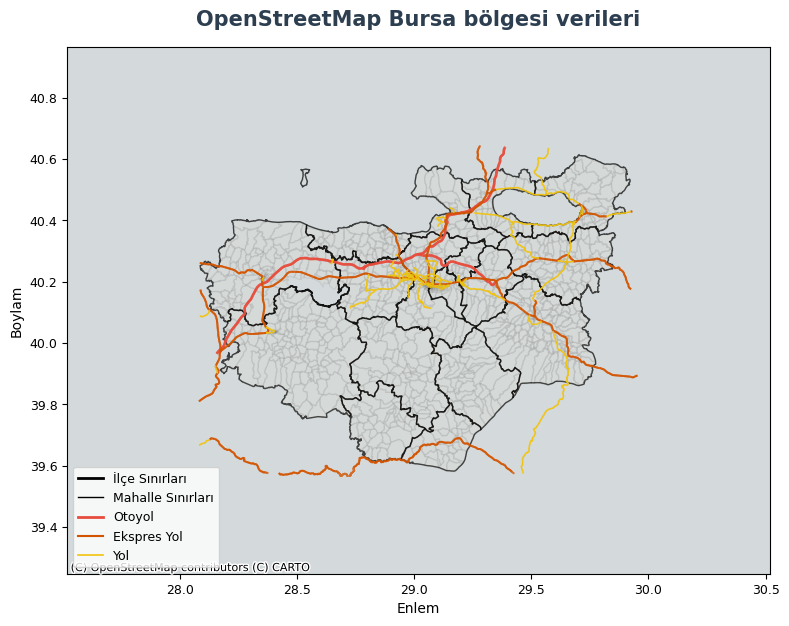

In [14]:
roads, districts, neighbourhoods = analyze_area(bbox, areaname)

### Çalışma alanına ait demografik verilerin temini

31 Aralık 2024 tarihli Adrese Dayalı Nüfus Kayıt Sistemi (ADNKS) verisi, TÜİK web sitesinden temin edilmiştir.

Veri, mahalle düzeyinde toplam nüfus, cinsiyet ve yaş grubu gibi demografik bilgileri içermektedir.

In [15]:
# tuik doesn't allow to download data with web requests so we have to use local file
file_path = '../data/bursa_nbh_pop.xls'

try:
    bursa_neighbourhood = pd.read_excel(file_path)
    print('Adrese Dayalı Nüfus Kayıt Sistemi verisinden mahalle nüfus verisi okundu.')
except Exception as e:
    print(f'CSV dosyası okunamadı: {e}')
    
file_path = '../data/bursa_district_age.xls'

try:
    bursa_district_age = pd.read_excel(file_path)
    print('Adrese Dayalı Nüfus Kayıt Sistemi verisinden ilçe yaş verisi okundu.')
except Exception as e:
    print(f'CSV dosyası okunamadı: {e}')

Adrese Dayalı Nüfus Kayıt Sistemi verisinden mahalle nüfus verisi okundu.
Adrese Dayalı Nüfus Kayıt Sistemi verisinden ilçe yaş verisi okundu.


### Verinin çalışma alanına uygun hale getirilmesi

TÜİK verilerinin ham formatındaki başlık satırları ve gereksiz sütunlar nedeniyle veriyi temizledikten sonra, mahalle ve ilçe bilgilerini içeren metinleri ayrıştırarak il, ilçe, belediye, mahalle gibi coğrafi bileşenleri ayrı sütunlara çıkarıyoruz.

In [16]:
# fixing the column names
bursa_nbh_fixed = bursa_neighbourhood.copy()
bursa_nbh_fixed.columns = bursa_nbh_fixed.iloc[3]
bursa_nbh_fixed = bursa_nbh_fixed.drop(index=range(0, 5)).reset_index(drop=True)
bursa_nbh_fixed = bursa_nbh_fixed.iloc[:, -2:]
bursa_nbh_fixed.columns = ['mahalle', 'nufus']

# parse 'mahalle' column: city(district/municipality/neighbourhood)-id
def parse_mahalle(val):
    main, id = val.rsplit('-', 1)
    city, rest = main.split('(', 1)
    rest = rest.rstrip(')')
    parts = rest.split('/')
    district, municipality, neighbourhood = parts
    return pd.Series([city.strip(), district, municipality, neighbourhood, id])

parsed = bursa_nbh_fixed['mahalle'].apply(parse_mahalle)
bursa_nbh_fixed = pd.concat([parsed, bursa_nbh_fixed['nufus']], axis=1)
bursa_nbh_fixed.columns = ['city', 'district', 'municipality', 'neighbourhood', 'id', 'nufus']

bursa_district_age_fixed = bursa_district_age.copy()
bursa_district_age_fixed = bursa_district_age_fixed.drop(bursa_district_age_fixed.columns[0], axis=1)
bursa_district_age_fixed.columns = bursa_district_age_fixed.iloc[1]
bursa_district_age_fixed = bursa_district_age_fixed.drop(index=[0,1,2,3]).reset_index(drop=True)
bursa_district_age_fixed = bursa_district_age_fixed.rename(columns={bursa_district_age_fixed.columns[0]: 'ilce'})

# parse 'ilce' column: city(district)-id
def parse_ilce(val):
    main, id = val.rsplit('-', 1)
    city, district = main.split('(')
    district = district.rstrip(')')
    return pd.Series([city.strip(), district.strip(), id.strip()])

parsed_district = bursa_district_age_fixed['ilce'].apply(parse_ilce)
parsed_district.columns = ['city', 'district', 'id']
bursa_district_age_fixed = pd.concat([parsed_district, bursa_district_age_fixed], axis=1)
bursa_district_age_fixed = bursa_district_age_fixed.drop(columns=['ilce'])

### Sipariş ve Depo Verilerinin Temini

Açıklama

Sipariş verisi okundu.
Depo verisi okundu.


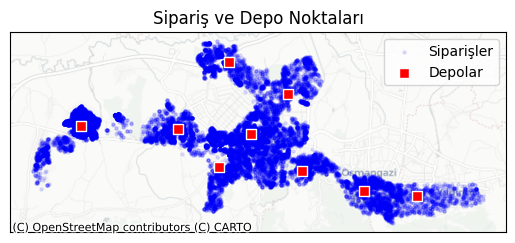

In [17]:
def load_data(path, name):
    try:
        df = pd.read_csv(path)
        print(f'{name} verisi okundu.')
        return df
    except Exception as e:
        print(f'{name} verisi okunamadı: {e}')
        return None

def find_coords(df):
    cols = {col.lower(): col for col in df.columns}
    try:
        return cols['longitude'], cols['latitude']
    except KeyError:
        raise KeyError(f"{df} verisinde 'longitude' ve/veya 'latitude' kolonları bulunamadı.")

order_df = load_data('../data/order.csv', 'Sipariş')
wh_df = load_data('../data/warehouse.csv', 'Depo')

if order_df is not None and wh_df is not None:
    s_long, s_lat = find_coords(order_df)
    w_long, w_lat = find_coords(wh_df)

    order_gdf = gpd.GeoDataFrame(order_df, geometry=gpd.points_from_xy(order_df[s_long], order_df[s_lat]), crs="EPSG:4326").to_crs(epsg=3857)
    wh_gdf = gpd.GeoDataFrame(wh_df, geometry=gpd.points_from_xy(wh_df[w_long], wh_df[w_lat]), crs="EPSG:4326").to_crs(epsg=3857)

    ax = order_gdf.plot(markersize=5, color='blue', label='Siparişler', alpha=0.1)
    wh_gdf.plot(ax=ax, markersize=50, color='red', marker='s', label='Depolar', edgecolor='white', linewidth=1)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    # 3857 projeksiyonu için eksen etiketlerini kaldır
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.legend()
    plt.title('Sipariş ve Depo Noktaları')
    plt.savefig(plot_dir + '/' + areaname + '_orders_warehouses.png')
    plt.show()
else:
    print('veri okunamadı')
    order_gdf = None
    wh_gdf = None 


## Sipariş Verisinin Mekansal Analizi

Açıklama

### Isı Haritası

Açıklama

#### Sipariş bazında

Açıklama

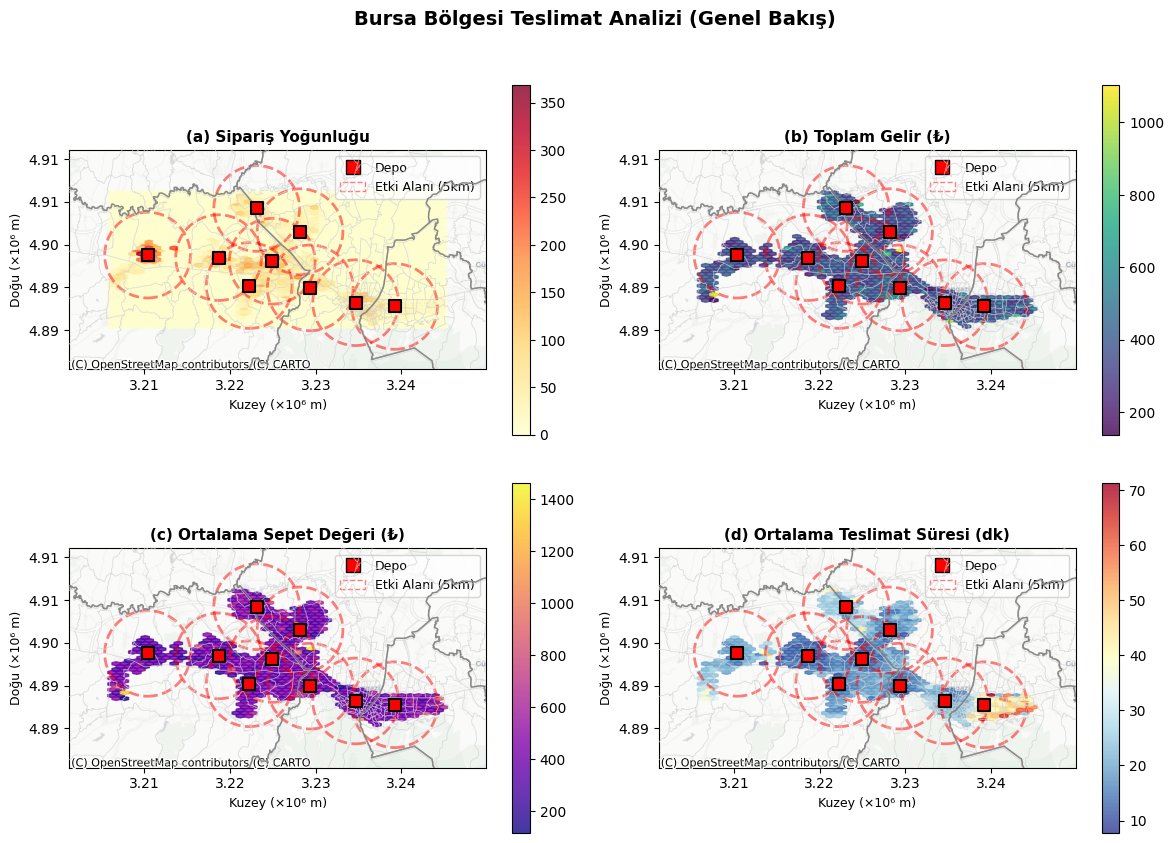

In [18]:
# convert to 3857 for analysis
order_3857 = order_gdf.to_crs(epsg=3857)
wh_3857 = wh_gdf.to_crs(epsg=3857)
x, y = order_3857.geometry.x.values, order_3857.geometry.y.values
w_x, w_y = wh_3857.geometry.x.values, wh_3857.geometry.y.values

revenue = order_gdf['revenue'].values
basket = order_gdf['basket_value'].values
delivery = order_gdf['delivery duration'].values

districts_3857 = districts.to_crs(epsg=3857)
nbh_3857 = neighbourhoods.to_crs(epsg=3857)

maps = [
    ('Sipariş Yoğunluğu', None, 'YlOrRd'),
    ('Toplam Gelir (₺)', revenue, 'viridis'),
    ('Ortalama Sepet Değeri (₺)', basket, 'plasma'),
    ('Ortalama Teslimat Süresi (dk)', delivery, 'RdYlBu_r')
]
labels = ['(a)', '(b)', '(c)', '(d)']
filenames = ['order_density', 'revenue_distribution', 'basket_value', 'delivery_duration']

def plot_hex(ax, data, cmap, title, label, single=False):
    districts_3857.boundary.plot(ax=ax, linewidth=1, edgecolor='grey', alpha=0.7, zorder=7)
    nbh_3857.boundary.plot(ax=ax, linewidth=0.5, edgecolor='lightgrey', alpha=0.5, zorder=6)
    # hexbins (need a fix)
    hb = ax.hexbin(x, y, C=data, gridsize=40, cmap=cmap, alpha=0.8, zorder=3)
    plt.colorbar(hb, ax=ax, shrink=0.8)
    # warehouse and buffer
    wh_handles = []
    buffer_handles = []
    for wx, wy in zip(w_x, w_y):
        # warehouse
        wh = ax.scatter(wx, wy, s=80, c='red', marker='s', edgecolor='black', linewidth=1.5, zorder=8, label='Depo')
        # buffer
        buf = ax.add_patch(plt.Circle((wx, wy), 5000, fill=False, color='red', linestyle='--', alpha=0.5, linewidth=2, zorder=5, label='Etki Alanı (5km)'))
        wh_handles.append(wh)
        buffer_handles.append(buf)
    #zoom into boundaries
    ax.set_xlim(order_3857.total_bounds[0] - 5000, order_3857.total_bounds[2] + 5000)
    ax.set_ylim(order_3857.total_bounds[1] - 5000, order_3857.total_bounds[3] + 5000)
    ax.set_aspect('equal')
    ax.set_title(f'{label} {title}', fontsize=11, weight='bold')
    ax.set_xlabel('Kuzey (×10⁶ m)', fontsize=9)
    ax.set_ylabel('Doğu (×10⁶ m)', fontsize=9)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val/1e6:.2f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val/1e6:.2f}'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)

    # custom legend
    wh_legend = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, markeredgecolor='black', label='Depo')
    buffer_legend = mpatches.Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=1, alpha=0.5, label='Etki Alanı (5km)')
    ax.legend(handles=[wh_legend, buffer_legend], loc='upper right', fontsize=9, frameon=True)

    if single:
        plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle(f'{areaname.capitalize()} Bölgesi Teslimat Analizi (Genel Bakış)', fontsize=14, weight='bold')

# saving plots
for i, (title, data, cmap) in enumerate(maps):
    ax = axes[i//2, i%2]
    plot_hex(ax, data, cmap, title, labels[i])
    fig_single, ax_single = plt.subplots(figsize=(12, 9))
    plot_hex(ax_single, data, cmap, title, labels[i], single=True)
    fig_single.savefig(f"{plot_dir}/{areaname}_{filenames[i]}.png", dpi=600)
    plt.close(fig_single)

plt.tight_layout()
plt.show()

#### Mahalle bazında

Açıklama

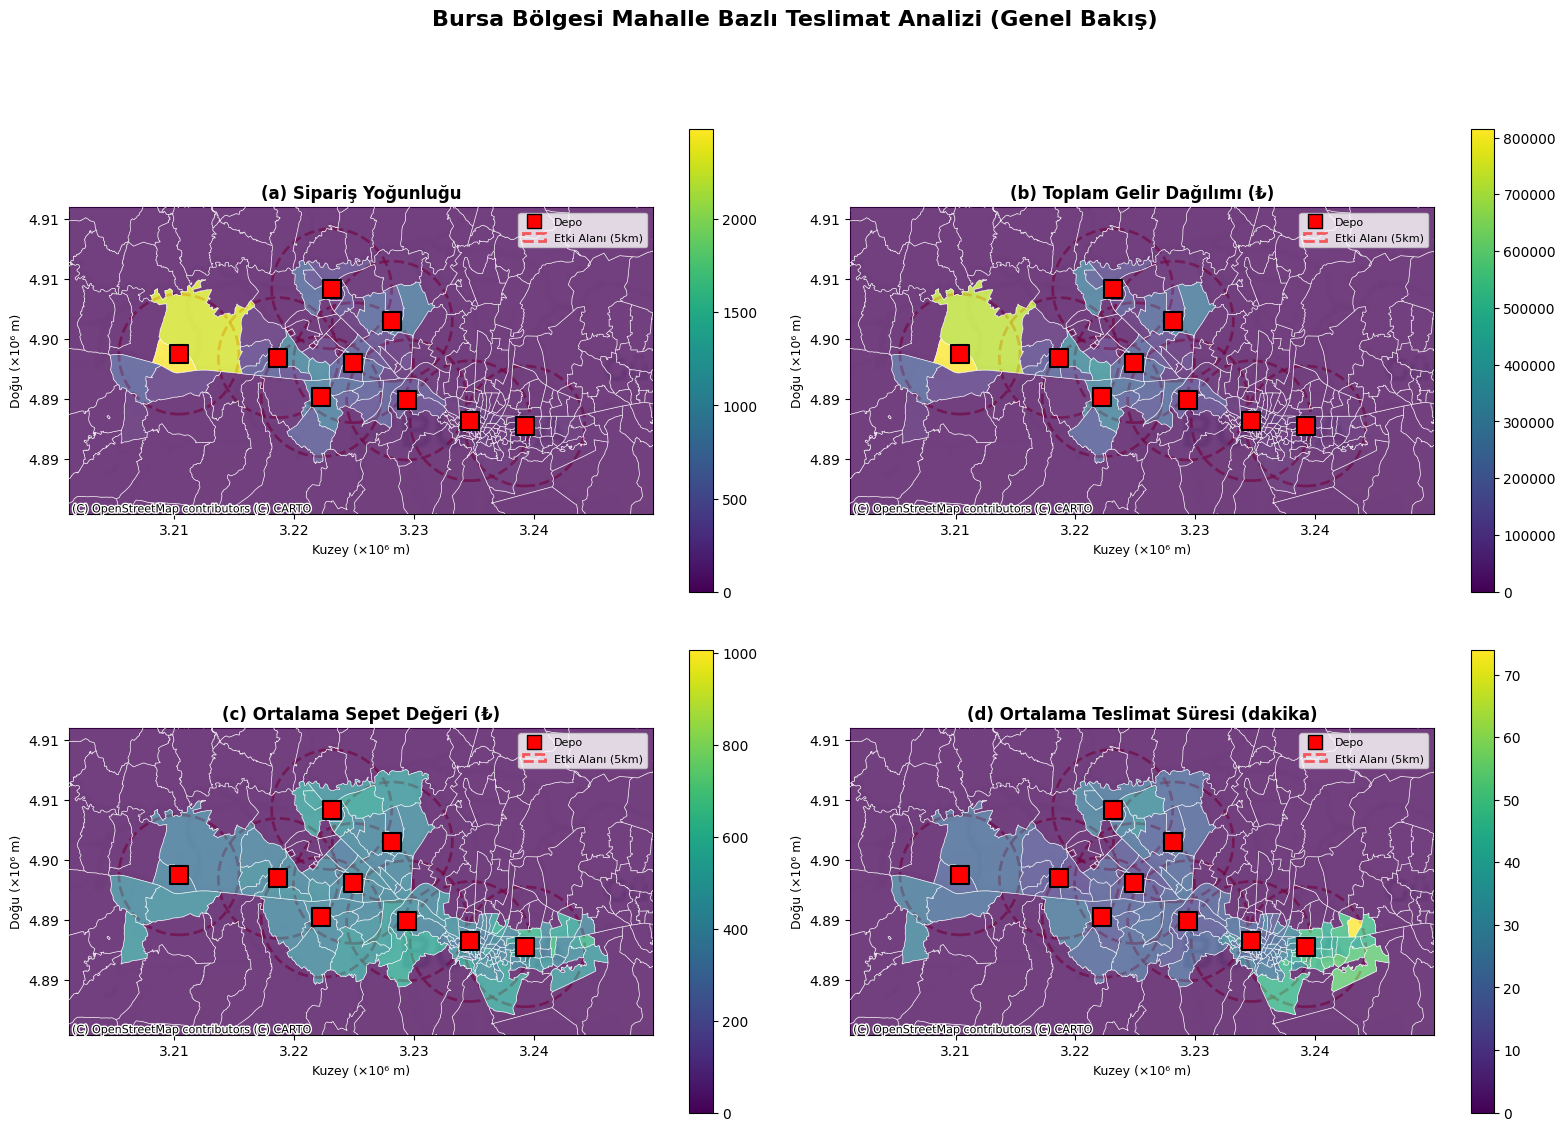

In [19]:
def nbh_based_analysis(order_gdf, nbh_gdf, wh_gdf):
    order_3857 = order_gdf.to_crs(epsg=3857)
    nbh_3857 = nbh_gdf.to_crs(epsg=3857)
    wh_3857 = wh_gdf.to_crs(epsg=3857)
    # spatial join to get mahalle-based statistics
    order_neighbourhood = gpd.sjoin(order_3857, nbh_3857, how='left', predicate='within')
    stats = order_neighbourhood.groupby('index_right').agg(
        revenue_sum=('revenue', 'sum'),
        revenue_mean=('revenue', 'mean'),
        revenue_count=('revenue', 'count'),
        basket_value_mean=('basket_value', 'mean'),
        basket_value_std=('basket_value', 'std'),
        delivery_duration_mean=('delivery duration', 'mean'),
        delivery_duration_std=('delivery duration', 'std')
    ).round(2).rename(columns={
        'revenue_sum': 'toplam_gelir',
        'revenue_mean': 'ortalama_gelir',
        'revenue_count': 'siparis_sayisi',
        'basket_value_mean': 'ortalama_sepet',
        'basket_value_std': 'sepet_std',
        'delivery_duration_mean': 'ortalama_teslimat',
        'delivery_duration_std': 'teslimat_std'
    })
    nbh_analysis = nbh_3857.reset_index().merge(stats, left_on='index', right_index=True, how='left')
    cols = ['toplam_gelir', 'ortalama_gelir', 'siparis_sayisi', 'ortalama_sepet', 'sepet_std', 'ortalama_teslimat', 'teslimat_std']
    nbh_analysis[cols] = nbh_analysis[cols].fillna(0)
    return nbh_analysis, wh_3857

def plot_neighbourhood(nbh_analysis, wh_3857, metrics, bounds, plot_dir, areaname="bolge"):
    os.makedirs(plot_dir, exist_ok=True)
    for metric, (label, title, filename) in metrics.items():
        fig, ax = plt.subplots(figsize=(12, 9))
        nbh_analysis.plot(column=metric, ax=ax, legend=True, cmap='viridis', edgecolor='white', linewidth=0.5,
                            legend_kwds={'shrink': 0.8, 'aspect': 20}, alpha=0.75, zorder=3)
        wh_3857.plot(ax=ax, color='red', marker='s', markersize=150, edgecolor='black', linewidth=1.5, zorder=4)
        for _, row in wh_3857.iterrows():
            ax.add_patch(Circle((row.geometry.x, row.geometry.y), 5000, fill=False, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=2))
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)
        ax.set_title(f'{label} {title}', fontsize=13, weight='bold')
        ax.set_xlabel('Kuzey (×10⁶ m)', fontsize=10)
        ax.set_ylabel('Doğu (×10⁶ m)', fontsize=10)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.set_xlim(bounds[0] - 5000, bounds[2] + 5000)
        ax.set_ylim(bounds[1] - 5000, bounds[3] + 5000)
        ax.set_aspect('equal')
        depo_leg = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, markeredgecolor='black', label='Depo')
        buffer_leg = mpatches.Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=2, alpha=0.6, label='Etki Alanı (5km)')
        ax.legend(handles=[depo_leg, buffer_leg], loc='upper right', fontsize=9)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"{areaname}_nbh_{filename}.png"), dpi=300, bbox_inches='tight')
        plt.close(fig)
    # 2x2 genel görünüm
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{areaname.capitalize()} Bölgesi Mahalle Bazlı Teslimat Analizi (Genel Bakış)', fontsize=16, weight='bold')
    for ax, (metric, (label, title, _)) in zip(axes.flat, metrics.items()):
        nbh_analysis.plot(column=metric, ax=ax, legend=True, cmap='viridis', edgecolor='white', linewidth=0.5,
                            legend_kwds={'shrink': 0.8, 'aspect': 20}, alpha=0.75, zorder=3)
        wh_3857.plot(ax=ax, color='red', marker='s', markersize=150, edgecolor='black', linewidth=1.5, zorder=4)
        for _, row in wh_3857.iterrows():
            ax.add_patch(Circle((row.geometry.x, row.geometry.y), 5000, fill=False, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=2))
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)
        ax.set_title(f'{label} {title}', fontsize=12, weight='bold')
        ax.set_xlabel('Kuzey (×10⁶ m)', fontsize=9)
        ax.set_ylabel('Doğu (×10⁶ m)', fontsize=9)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.set_xlim(bounds[0] - 5000, bounds[2] + 5000)
        ax.set_ylim(bounds[1] - 5000, bounds[3] + 5000)
        ax.set_aspect('equal')
        depo_leg = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, markeredgecolor='black', label='Depo')
        buffer_leg = mpatches.Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=2, alpha=0.6, label='Etki Alanı (5km)')
        ax.legend(handles=[depo_leg, buffer_leg], loc='upper right', fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(os.path.join(plot_dir, f"{areaname}_nbh_analysis_grid.png"), dpi=300, bbox_inches='tight')
    plt.show()

os.makedirs(plot_dir, exist_ok=True)
nbh_analysis, wh_3857 = nbh_based_analysis(order_gdf, neighbourhoods, wh_gdf)
metrics = {
    'siparis_sayisi': ('(a)', 'Sipariş Yoğunluğu', 'order_density'),
    'toplam_gelir': ('(b)', 'Toplam Gelir Dağılımı (₺)', 'revenue_distribution'),
    'ortalama_sepet': ('(c)', 'Ortalama Sepet Değeri (₺)', 'basket_value'),
    'ortalama_teslimat': ('(d)', 'Ortalama Teslimat Süresi (dakika)', 'delivery_duration')
}
bounds = order_gdf.to_crs(epsg=3857).total_bounds
plot_neighbourhood(nbh_analysis, wh_3857, metrics, bounds, plot_dir=plot_dir, areaname=areaname)

## Optimum Servis Alanlarının Tasarlanması

Açıklama

In [ ]:
# Depo mesafelerini hesapla
order_3857_wc = order_3857.copy()
order_3857_wc['closest_wh'] = order_3857_wc.apply(
    lambda x: np.argmin([((x.latitude-w.Latitude)**2 + (x.longitude-w.Longitude)**2)**0.5 for _, w in wh_3857.iterrows()]), axis=1
)

# Mahalle bazlı sipariş yoğunluğu
nbh_orders = gpd.sjoin(order_3857_wc, nbh_3857, how='left', predicate='within')
nbh_stats = nbh_orders.groupby('id').agg({'profit': 'sum', 'revenue': 'sum', 'order_id': 'count'}).reset_index()

# mahalle verisini nüfus verisi ile birleştirme
districts_merge = districts.copy()
bursa_nbh_fixed_merge = bursa_nbh_fixed.copy()
nbh_stats_merge = nbh_stats.copy()

# making sure the ids are int
districts_merge['id'] = districts_merge['id'].astype(int)
bursa_nbh_fixed_merge['id'] = bursa_nbh_fixed_merge['id'].astype(int)
nbh_stats_merge['id'] = nbh_stats_merge['id'].astype(int)
nbh_3857['id'] = nbh_3857['id'].astype(int)
bursa_nbh_fixed_merge['id'] = bursa_nbh_fixed_merge['id'].astype(int)
nbh_stats_merge['id'] = nbh_stats_merge['id'].astype(int)

# Only keep neighbourhoods that exist in ADNKS and stats
valid_id = set(bursa_nbh_fixed_merge['id']) & set(nbh_stats_merge['id'])
nbh_full = nbh_3857[nbh_3857['id'].isin(valid_id)].copy()
nbh_full = nbh_full.merge(
    bursa_nbh_fixed_merge, on='id', how='left', suffixes=('', '_adnks')
).merge(
    nbh_stats_merge, on='id', how='left', suffixes=('', '_stats')
)
# sipariş yoğunluğu hesapla
nbh_full['order_density'] = nbh_full['order_id'] / nbh_full['nufus'] * 1000
nbh_full['profit_per_capita'] = nbh_full['profit'] / nbh_full['nufus']

In [21]:
# Voronoi + Performance hibrit
def create_optimized_zones(orders, warehouses, method='balanced'):
    if method == 'balanced':
        weights = {'profit': 0.3, 'delivery duration': -0.2, 'basket_value': 0.2, 'distance': -0.3}
    
    for i, order in orders.iterrows():
        scores = []
        for j, wh in warehouses.iterrows():
            dist = ((order.latitude - wh.Latitude)**2 + (order.longitude - wh.Longitude)**2)**0.5
            score = (
                weights['profit'] * order.profit / 100 +
                weights['delivery duration'] * order['delivery duration'] / 10 +
                weights['basket_value'] * order.basket_value / 100 +
                weights['distance'] * dist
            )
            scores.append(score)
        orders.loc[i, 'opt_wh'] = np.argmax(scores)
    
    return orders

orders_opt = create_optimized_zones(order_3857_wc, wh_3857)


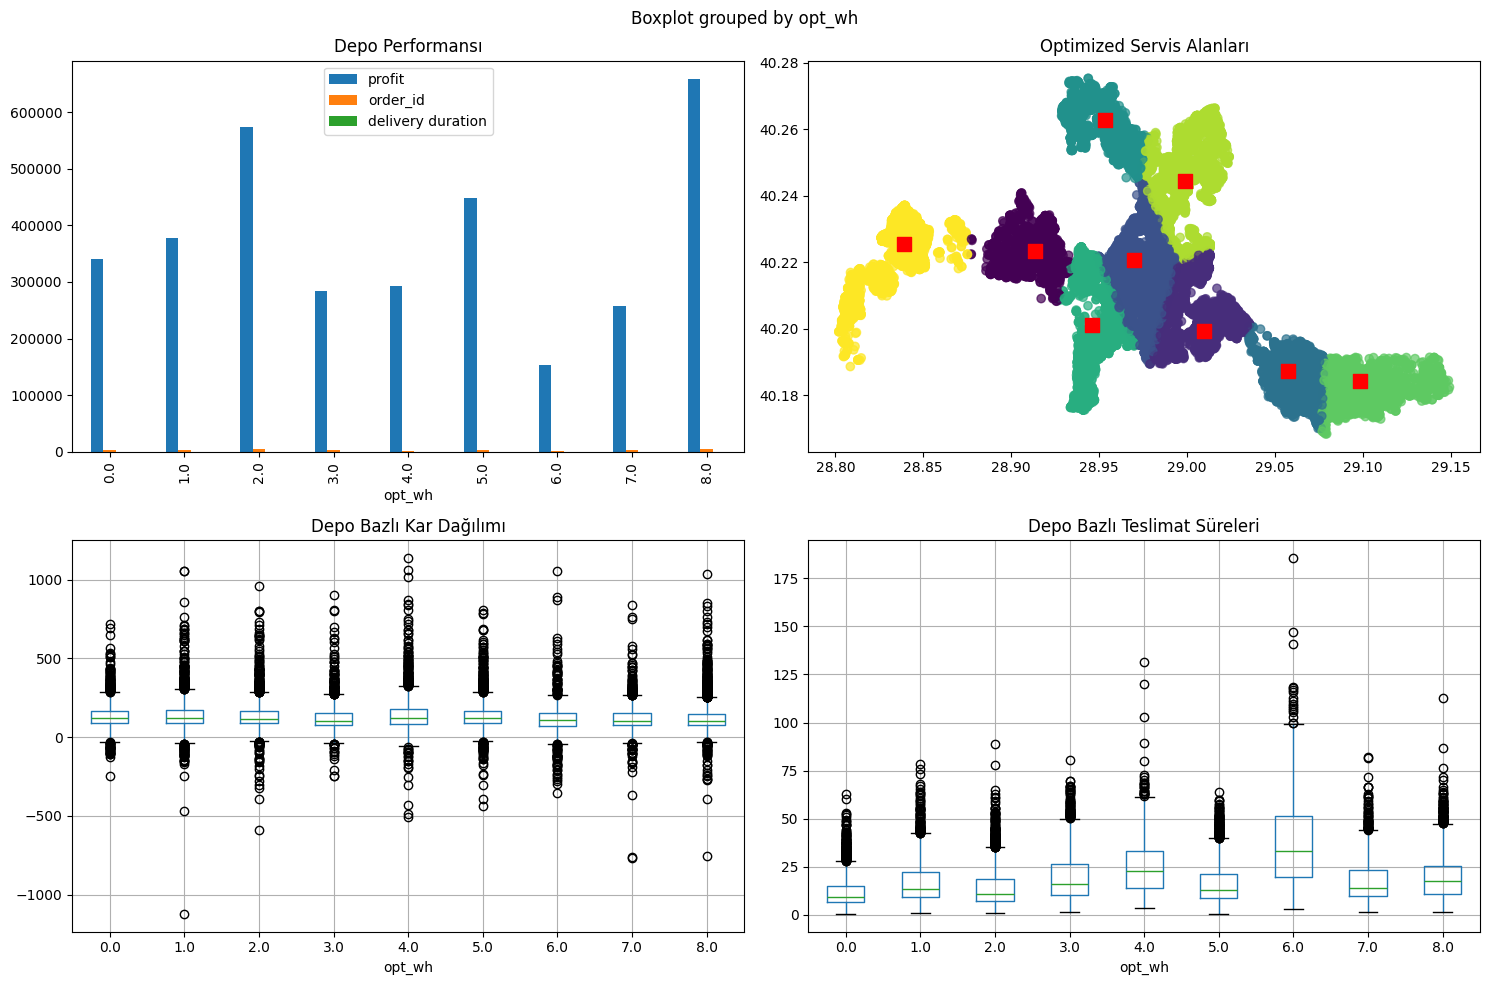

In [22]:
def create_kpi_dashboard(orders, warehouses):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Depo performansı
    wh_stats = orders.groupby('opt_wh').agg({'profit': 'sum', 'order_id': 'count', 'delivery duration': 'mean'})
    wh_stats.plot(kind='bar', ax=axes[0,0], title='Depo Performansı')
    
    # Coğrafi dağılım
    axes[0,1].scatter(orders.longitude, orders.latitude, c=orders.opt_wh, cmap='viridis', alpha=0.7)
    axes[0,1].scatter(warehouses.Longitude, warehouses.Latitude, c='red', s=100, marker='s')
    axes[0,1].set_title('Optimized Servis Alanları')
    
    # Kar dağılımı
    orders.boxplot(column='profit', by='opt_wh', ax=axes[1,0])
    axes[1,0].set_title('Depo Bazlı Kar Dağılımı')
    
    # Teslimat süreleri
    orders.boxplot(column='delivery duration', by='opt_wh', ax=axes[1,1])
    axes[1,1].set_title('Depo Bazlı Teslimat Süreleri')
    
    plt.tight_layout()
    plt.show()
    
    return wh_stats

kpi_results = create_kpi_dashboard(orders_opt, wh_3857)

## Servis Alanları KPI Analizi

## Haritalandırma